In [128]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

from data_cleaning import data_cleaning
from data_loader import feature_extraction_dataloader

test_size = 0.15
seed = 9
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [ ]:
data_cleaning(False, True)

In [ ]:
warnings.filterwarnings('ignore')
loader = feature_extraction_dataloader()
loader.write_data(rgb=False)

### load saved data

In [2]:
data = sio.loadmat(os.path.join('data_set', 'img_feature.mat'))

### normalize data

In [3]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [4]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (672, 532)
Test data    : (119, 532)
Train labels : (672,)
Test labels  : (119,)


### use cross validation to find out the performance of each model

In [131]:
rf_gini_acc = []
rf_gini_time_list = []
rf_entropy_acc = []
rf_entropy_time_list = []
rf_loss_f_n_list = np.hstack([np.array([10,50,100,500]),np.linspace(600,1500,num=5)])
for n in rf_loss_f_n_list:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training gini, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_gini_time_list.append(time_elapsed)
    rf_gini_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training entropy, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_entropy_time_list.append(time_elapsed)
    rf_entropy_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training gini, n_estimators: 10.0, accuracy: 0.729, std: 0.045
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 10.0, accuracy: 0.729, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training gini, n_estimators: 50.0, accuracy: 0.810, std: 0.019
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 50.0, accuracy: 0.811, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 100.0, accuracy: 0.823, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 100.0, accuracy: 0.827, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 500.0, accuracy: 0.841, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 500.0, accuracy: 0.832, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 7s
[CROSS_VAL_SCORE] Training gini,

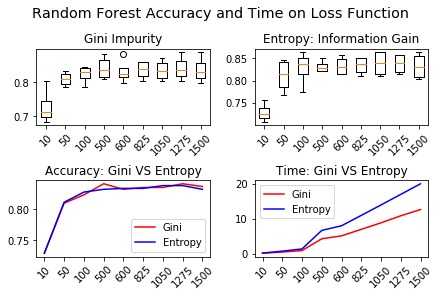

In [139]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 2)
fig.suptitle('Random Forest Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0:3,0])
plt.boxplot(rf_gini_acc)
ax1.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Gini Impurity')
plt.xticks(rotation=45, horizontalalignment="center")

ax2 = fig.add_subplot(gs[0:3,1 ])
plt.boxplot(rf_entropy_acc)
ax2.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Entropy: Information Gain')
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,0])
plt.title('Accuracy: Gini VS Entropy')
plt.plot([str(int(x)) for x in n_list], [x.mean() for x in rf_gini_acc], c='r', label='Gini')
plt.plot([str(int(x)) for x in n_list], [x.mean() for x in rf_entropy_acc], c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,1])
plt.title('Time: Gini VS Entropy')
plt.plot([str(int(x)) for x in n_list], rf_gini_time_list, c='r', label='Gini')
plt.plot([str(int(x)) for x in n_list], rf_entropy_time_list, c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
plt.show()

In [136]:
acc = []
time_list = []
n_list_2 = np.hstack([np.array([10,50,100,500]),np.linspace(600,1400,num=5),np.array([3000,5000])])
for n in n_list_2:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training n_estimators: {} : accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    time_list.append(time_elapsed)
    acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


[CROSS_VAL_SCORE] Training n_estimators: 10.0 : accuracy: 0.759, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 50.0 : accuracy: 0.820, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 100.0 : accuracy: 0.832, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training n_estimators: 500.0 : accuracy: 0.833, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 4s
[CROSS_VAL_SCORE] Training n_estimators: 600.0 : accuracy: 0.838, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training n_estimators: 800.0 : accuracy: 0.833, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 7s
[CROSS_VAL_SCORE] Training n_estimators: 1000.0 : accuracy: 0.841, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 8s
[CROSS_VAL_SCORE] Training n_estimators: 1200.0 : accuracy: 0.835, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 10s
[CROSS_VAL_SCORE] Training n_estimators: 1400.0 : accuracy: 0.844, std: 0.030
[

[array([0.81547619, 0.73809524, 0.71428571, 0.67857143]), array([0.85714286, 0.80357143, 0.79166667, 0.82738095]), array([0.8452381 , 0.81547619, 0.76785714, 0.82142857]), array([0.88095238, 0.81547619, 0.80357143, 0.81547619]), array([0.875     , 0.82142857, 0.80952381, 0.85714286]), array([0.86309524, 0.80952381, 0.80357143, 0.85119048]), array([0.86904762, 0.82142857, 0.80952381, 0.85714286]), array([0.875     , 0.82738095, 0.79166667, 0.86309524]), array([0.88095238, 0.82738095, 0.80952381, 0.8452381 ]), array([0.86309524, 0.81547619, 0.80952381, 0.85119048]), array([0.86904762, 0.82738095, 0.81547619, 0.85119048])]
[  10.   50.  100.  500.  600.  825. 1050. 1275. 1500. 3000. 5000.]


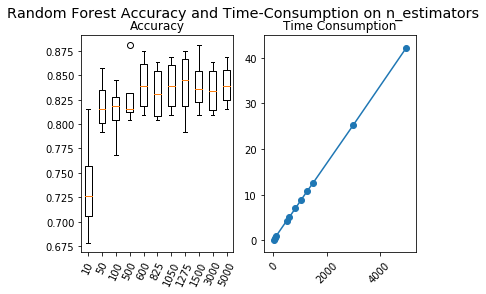

In [127]:
fig = plt.figure()
fig.suptitle("Random Forest Accuracy and Time-Consumption on n_estimators", fontsize='x-large')
ax = fig.add_subplot(121)
plt.boxplot(acc)
ax.set_xticklabels([int(x) for x in n_list_2])
plt.xticks(rotation=65, horizontalalignment="center")
plt.title('Accuracy')
ax = fig.add_subplot(1,2,2)
ax.plot([int(x) for x in n_list], time_list)
ax.scatter([int(x) for x in n_list], time_list)
plt.xticks(rotation=45, horizontalalignment="center")
plt.title('Time Consumption')
plt.show()

In [173]:
svm_ker_acc = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_time_list = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_n_list = np.hstack([np.linspace(1,5,5),8,10,20,50,100])
for c in svm_ker_n_list:
    for ker in ["linear", "poly", 'rbf', 'sigmoid']:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel=ker, C=c, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(ker,c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_ker_time_list[ker].append(time_elapsed)
        svm_ker_acc[ker].append(cv_results)
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: linear, C = 1.0, accuracy: 0.775, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 1.0, accuracy: 0.756, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 1.0, accuracy: 0.738, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 1.0, accuracy: 0.661, std: 0.012
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: linear, C = 2.0, accuracy: 0.787, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.781, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 2.0, accuracy: 0.774, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 2.0, accuracy: 0.702, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: linear, C = 3.0, accuracy: 0.

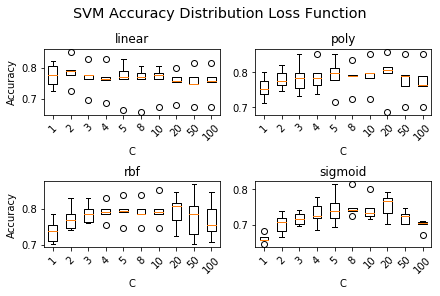

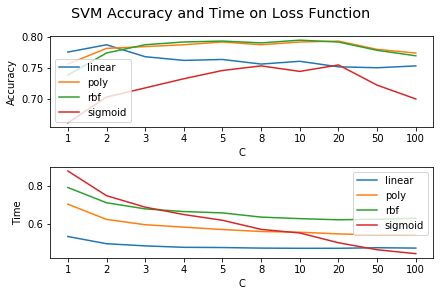

In [174]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
fig.suptitle('SVM Accuracy Distribution Loss Function', fontsize='x-large')

for i, key in enumerate(svm_ker_acc.keys()):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    plt.boxplot(svm_ker_acc[key])
    ax.set_xticklabels([int(x) for x in svm_ker_n_list])
    if i%2 == 0:
        plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.title(key)
    plt.xticks(rotation=45, horizontalalignment="center")

plt.show()



fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2)
fig.suptitle('SVM Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax1.plot([str(int(x)) for x in svm_ker_n_list], [x.mean() for x in svm_ker_acc[key]], label=key)
plt.ylabel('Accuracy')
plt.xlabel('C')
ax1.legend()

ax2 = fig.add_subplot(gs[1,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax2.plot([str(int(x)) for x in svm_ker_n_list], svm_ker_time_list[key], label=key)
plt.ylabel('Time')
plt.xlabel('C')
ax2.legend()
plt.show()

## Use poly

In [181]:
# C of poly
svm_C_acc = []
svm_C_time_list = []
svm_C_n_list = np.linspace(2,30,29)
for c in svm_C_n_list:
    since = time.time()
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    model = SVC(random_state=seed, kernel='poly', C=c, decision_function_shape='ovo')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training kernal: poly, C = {}, accuracy: {:.3f}, std: {:.3f}".format(c, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    svm_C_time_list.append(time_elapsed)
    svm_C_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.781, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 3.0, accuracy: 0.784, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 4.0, accuracy: 0.787, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 5.0, accuracy: 0.792, std: 0.045
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 6.0, accuracy: 0.798, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 7.0, accuracy: 0.793, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 8.0, accuracy: 0.787, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 9.0, accuracy: 0.787, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 10.0, accuracy: 0.792, std:

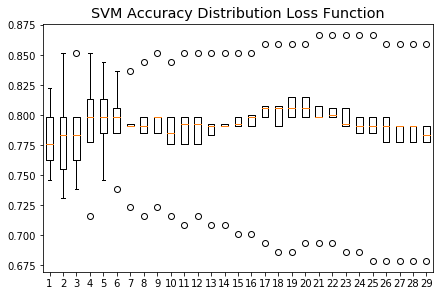

In [185]:
plt.figure(constrained_layout=True)
plt.title('SVM Accuracy Distribution Loss Function', fontsize='x-large')
ax = fig.add_subplot(111)
plt.boxplot(svm_C_acc)
ax.set_xticklabels([int(x) for x in svm_C_n_list])
plt.show()

# c = 6

In [ ]:
num_trees = 1150
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=1000, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='gini', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed)}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [ ]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### Best model: Random Froest
We build some examples using random forest model.

In [ ]:
best_model = models['RF']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.extract_single_image(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

In [ ]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()